In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import plot_confusion_matrix, roc_curve, f1_score, plot_roc_curve, balanced_accuracy_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from pandas.api.types import is_numeric_dtype
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

%matplotlib inline

# German Credit Data 

## Objective

* Evaluate the credit-worthiness of the borrowers in this dataset, the response variable is the 'default' indicator (0 or 1)

## Initial data Load, Quality Check, and Test/Train split

In [2]:
credit_data = pd.read_csv('/artifacts/german_credit.csv')
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   default                     1000 non-null   int64 
 1   account_check_status        1000 non-null   object
 2   duration_in_month           1000 non-null   int64 
 3   credit_history              1000 non-null   object
 4   purpose                     1000 non-null   object
 5   credit_amount               1000 non-null   int64 
 6   savings                     1000 non-null   object
 7   present_emp_since           1000 non-null   object
 8   installment_as_income_perc  1000 non-null   int64 
 9   personal_status_sex         1000 non-null   object
 10  other_debtors               1000 non-null   object
 11  present_res_since           1000 non-null   int64 
 12  property                    1000 non-null   object
 13  age                         1000 non-null   int64

####  Examine categorical / ordinal attributes (string attributes)

In [3]:


categorical_attrs = [c for c in credit_data.columns if not is_numeric_dtype(credit_data[c].dtype)]
credit_data[categorical_attrs].apply(lambda c: c.value_counts()).T.stack()

account_check_status     0 <= ... < 200 DM                                                   269.0
                         < 0 DM                                                              274.0
                         >= 200 DM / salary assignments for at least 1 year                   63.0
                         no checking account                                                 394.0
credit_history           all credits at this bank paid back duly                              49.0
                         critical account/ other credits existing (not at this bank)         293.0
                         delay in paying off in the past                                      88.0
                         existing credits paid back duly till now                            530.0
                         no credits taken/ all credits paid back duly                         40.0
purpose                  (vacation - does not exist?)                                         50.0
          

In [4]:
credit_data[categorical_attrs + ['default']] = credit_data[categorical_attrs + ['default']].astype('category')

#### Examine numeric attributes

In [5]:
numeric_attrs = [c for c in credit_data.columns if is_numeric_dtype(credit_data[c].dtype)]
credit_data[numeric_attrs].describe()

,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


#### Test Train Split

In [6]:
train_data, test_data = train_test_split(credit_data, train_size = 0.7, stratify=credit_data['default'])
train_data, test_data = train_data.copy(), test_data.copy()

In [7]:
pd.concat((
    train_data.default.value_counts(),
    test_data.default.value_counts()))

0    490
1    210
0    210
1     90
Name: default, dtype: int64

### Feature Engineer

Which numeric attributes are most correlated with default?

In [8]:
train_data['default'] = train_data['default'].astype('int64')
train_data.corr(method='kendall')

,default,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance
default,1.000000,0.178274,0.097314,0.036695,0.002236,-0.106608,-0.020017,-0.012620
duration_in_month,0.178274,1.000000,0.464191,0.106814,0.032883,-0.045824,0.026254,-0.046674
credit_amount,0.097314,0.464191,1.000000,-0.231494,0.038423,0.020552,0.009571,0.045291
installment_as_income_perc,0.036695,0.106814,-0.231494,1.000000,0.019695,0.027438,0.021588,-0.099734
present_res_since,0.002236,0.032883,0.038423,0.019695,1.000000,0.197854,0.047543,0.037829
age,-0.106608,-0.045824,0.020552,0.027438,0.197854,1.000000,0.118788,0.172406
credits_this_bank,-0.020017,0.026254,0.009571,0.021588,0.047543,0.118788,1.000000,0.089075
people_under_maintenance,-0.012620,-0.046674,0.045291,-0.099734,0.037829,0.172406,0.089075,1.000000


Noteable, although weak correlations: 
* Duration in months (makes sense)
* Age is negatively correlated

Try using in a decision tree to see where we end up (use to create bins)

In [9]:
class_wts = {0: 1, 1:(490.0/210.0)}

x_train = np.asmatrix(train_data['age']).T
y_train = train_data['default']

age_dtree = DecisionTreeClassifier(class_weight=class_wts, max_depth = 1)

cross_val_score(age_dtree, x_train, y_train, groups=y_train)

array([0.71428571, 0.6       , 0.62142857, 0.67857143, 0.62857143])

Looks like we've got some signal, find the split and look for consistency

In [10]:
age_dtree_cv = cross_validate(age_dtree, x_train, y_train, groups=y_train, return_estimator=True)

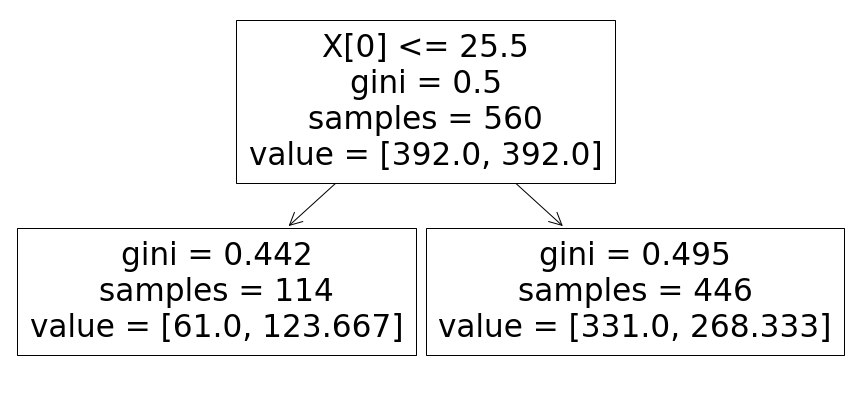

In [11]:
fig = plt.figure(figsize=(15,7))

_ = plot_tree(age_dtree_cv['estimator'][2])

Check for interations

In [12]:
interaction_dtree = DecisionTreeClassifier(class_weight=class_wts, max_depth = 2)

x_train = np.asmatrix(train_data[numeric_attrs])
y_train = train_data['default']

cross_val_score(interaction_dtree, x_train, y_train, groups=y_train)

array([0.70714286, 0.55      , 0.50714286, 0.67142857, 0.65714286])

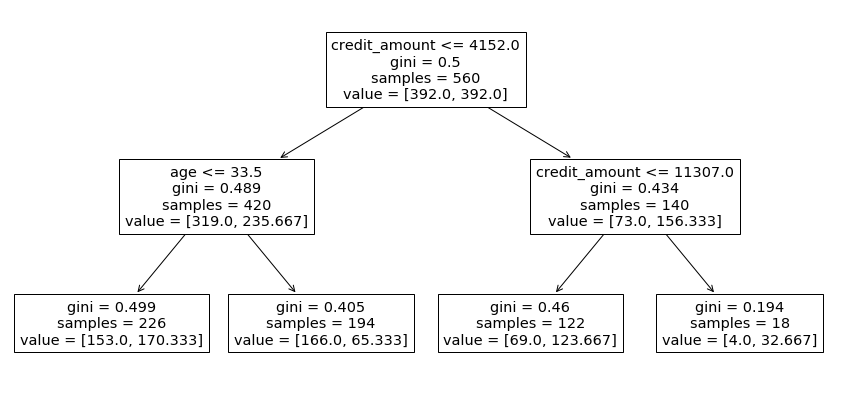

In [13]:
fig = plt.figure(figsize=(15,7))

interaction_dtree_cv = cross_validate(interaction_dtree, x_train, y_train, groups=y_train, return_estimator=True)

_ = plot_tree(interaction_dtree_cv['estimator'][2], feature_names=numeric_attrs)

In [14]:
interaction_dtree_cv['test_score']

array([0.70714286, 0.55      , 0.50714286, 0.67142857, 0.65714286])

In [15]:
(interaction_dtree_cv['test_score'].mean(), interaction_dtree_cv['test_score'].std())

(0.6185714285714285, 0.07647862179613814)

The following interactions may exist:

* Credit amount and duration in months
* Credit amount and present residence since since

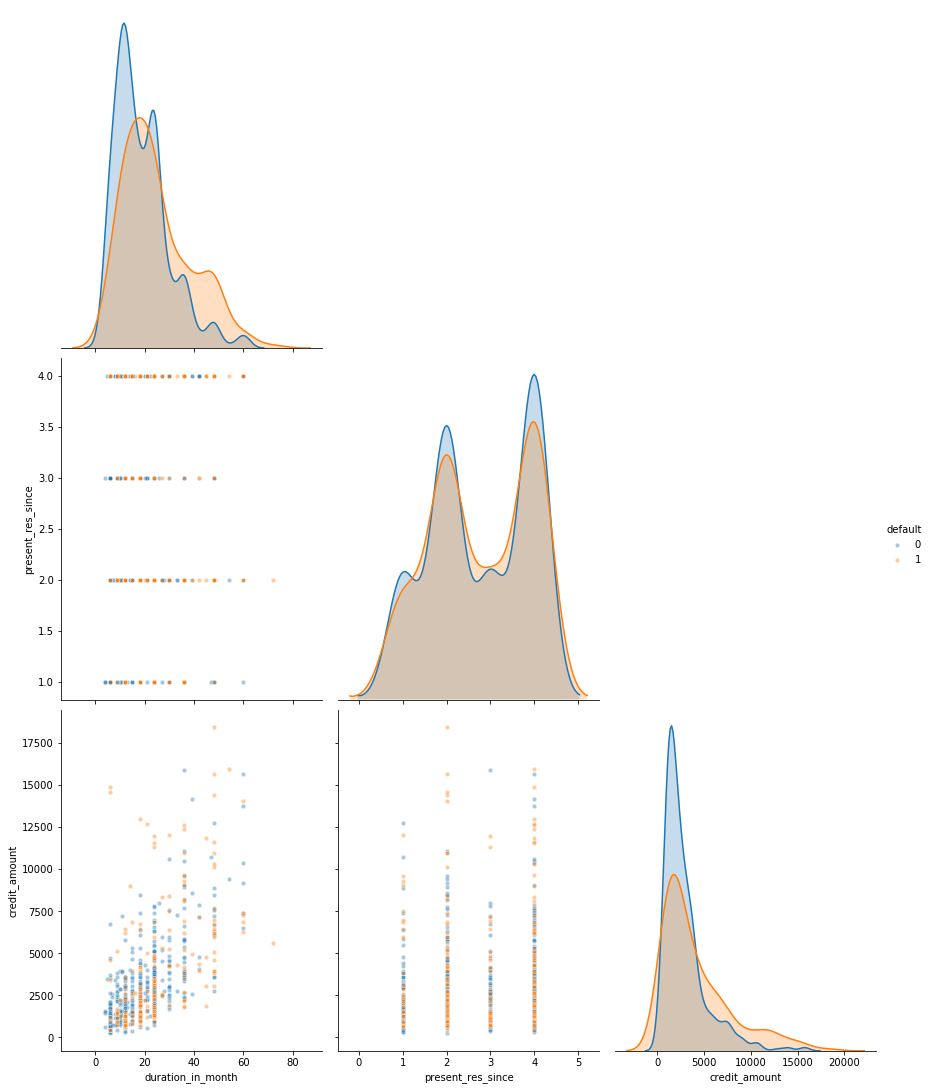

In [16]:
_=sns.pairplot(train_data, 
             x_vars=['duration_in_month', 'present_res_since', 'credit_amount'],
             y_vars=['duration_in_month', 'present_res_since', 'credit_amount'],
             hue="default", 
             height=5,
             aspect=0.8,
             corner=True,
             plot_kws={'alpha':0.4, 's':20})

Take a closer look at duration in month and credit amount, especially on the right (low credit amount, long duration).  There is evidence of an interaction.

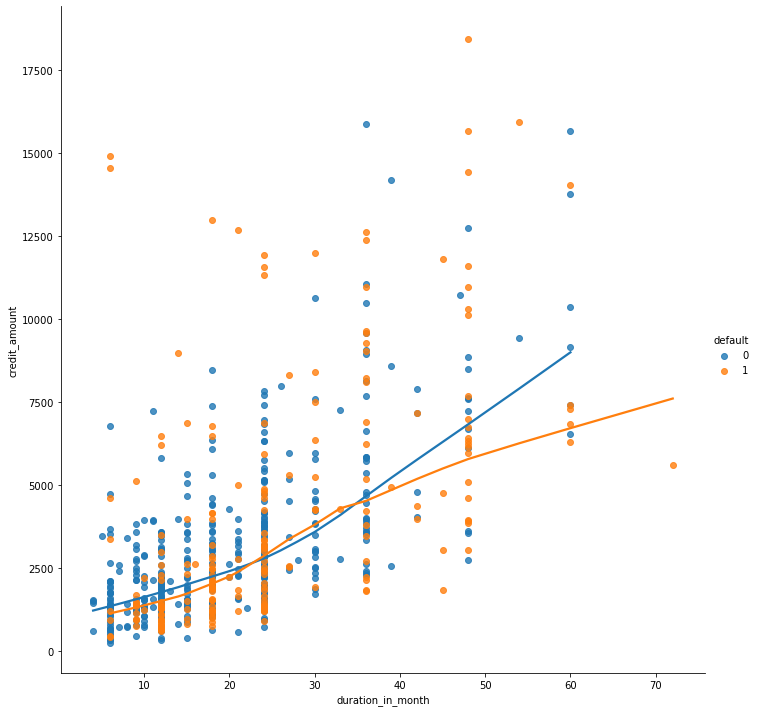

In [17]:
sns.lmplot('duration_in_month', 'credit_amount', train_data, hue='default', lowess=True, height=10)

Which categorical attributes are most correlated with default?  Use a decision tree.

In [18]:
x_train = pd.get_dummies(train_data[categorical_attrs])
y_train = train_data['default']

dtree_model = DecisionTreeClassifier(class_weight={0:1, 1:(490.0/210.0)}, max_depth=3)
dtree_model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 2.3333333333333335}, max_depth=3)

Check the top 5 features from the decision tree:

In [19]:
sorted(
    zip(dtree_model.feature_importances_, x_train.columns.to_list()),
    key=lambda x: x[0],
    reverse=True)[0:5]

[(0.6489383293789814, 'account_check_status_no checking account'),
 (0.1024812114579527,
  'account_check_status_>= 200 DM / salary assignments for at least 1 year'),
 (0.0918731289099915, 'other_installment_plans_none'),
 (0.0642664823590097, 'property_real estate'),
 (0.04568936325690585, 'savings_... < 100 DM')]

Plot the tree:

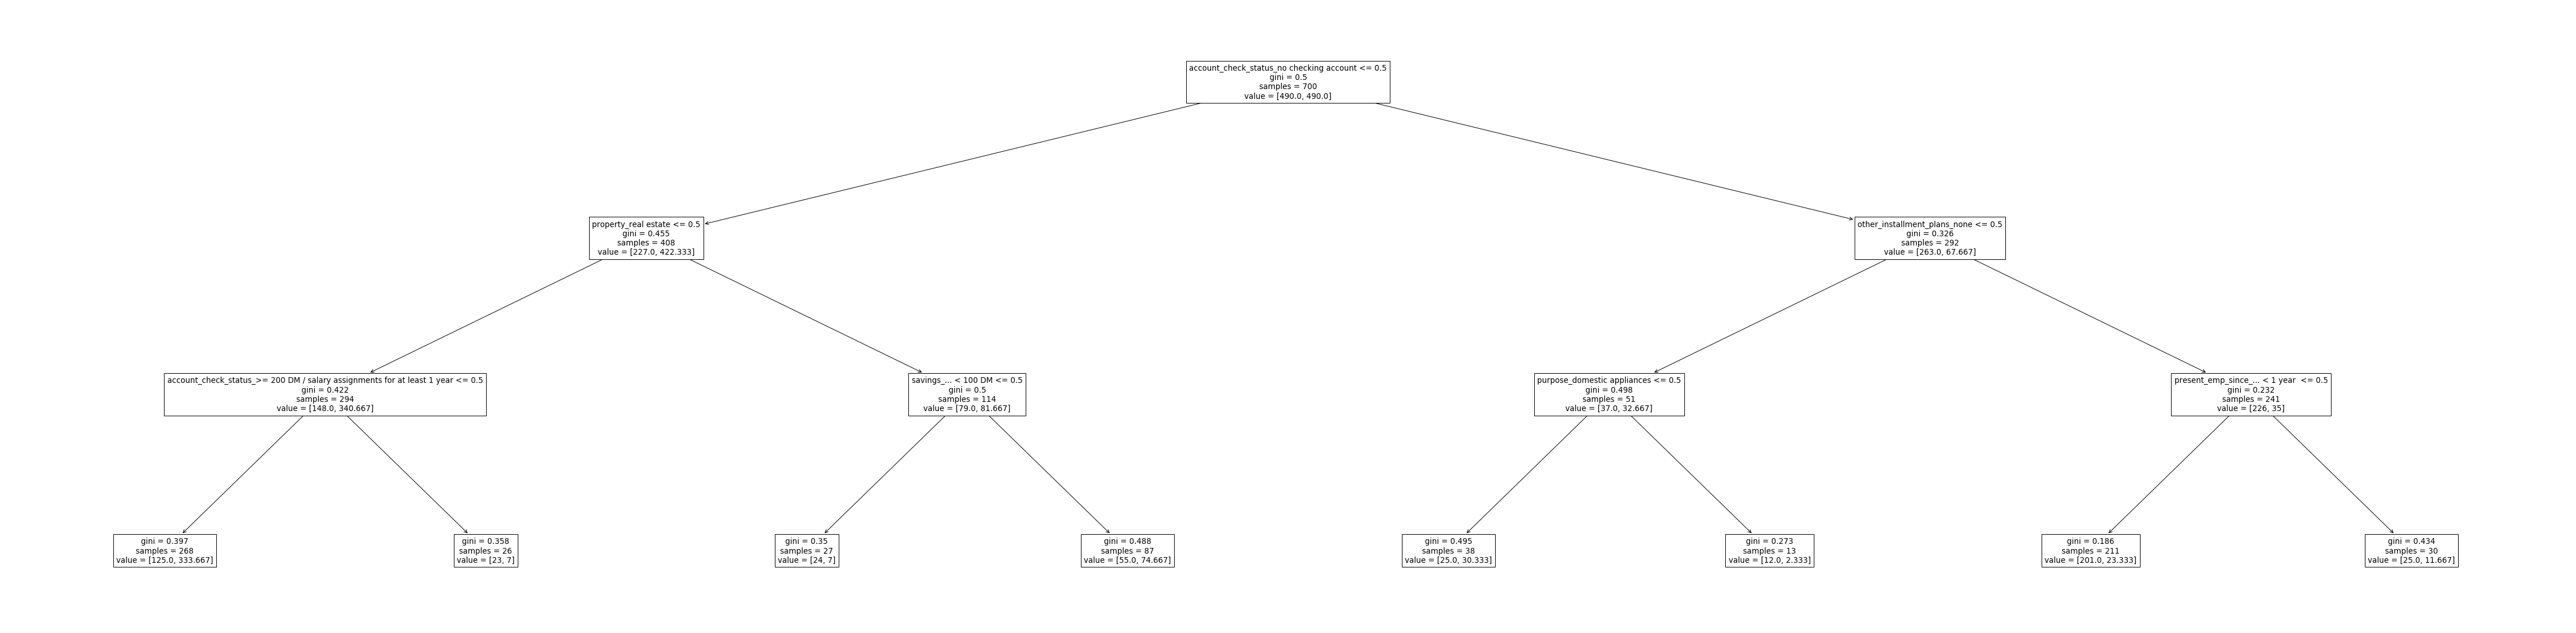

In [20]:
fig = plt.figure(figsize=(80,20))
tree_desc = plot_tree(dtree_model, feature_names=x_train.columns.to_list(), max_depth=3)

Grab the cross-validated output to later check if we are improving performance by binning

Based on decision tree output, re-encode the savings and account check status as ordinals, keep an indicator for "no checking account".

In [21]:
credit_data.account_check_status.cat.reorder_categories(
    ['no checking account', '< 0 DM', '0 <= ... < 200 DM', '>= 200 DM / salary assignments for at least 1 year'],
    ordered=True,
    inplace=True)

credit_data.savings.cat.reorder_categories(
    ['unknown/ no savings account', '... < 100 DM', '100 <= ... < 500 DM', '500 <= ... < 1000 DM ', '.. >= 1000 DM '],
    ordered=True,
    inplace=True)

In [22]:
ordinal_attrs = ['account_check_status', 'savings']
new_categorical_attrs = [c for c in categorical_attrs if c not in ordinal_attrs]
new_numeric_attrs = numeric_attrs + ordinal_attrs

x_train = pd.concat((
    train_data[numeric_attrs],
    train_data[ordinal_attrs].apply(lambda x: x.cat.codes),
    pd.get_dummies(train_data[new_categorical_attrs])),
    axis=1)

In [23]:
combined_dtree = DecisionTreeClassifier(max_depth=4)
combined_dtree_cv = cross_validate(combined_dtree, x_train.to_numpy(), y_train, groups=y_train, return_estimator=True)

In [24]:
combined_dtree_cv['test_score']

array([0.74285714, 0.74285714, 0.66428571, 0.73571429, 0.73571429])

In [25]:
(combined_dtree_cv['test_score'].mean(), combined_dtree_cv['test_score'].std()) 

(0.7242857142857143, 0.03016958868848985)

In [26]:
x_train.columns.to_list()
feature_importances = list(map(lambda x: zip(x.feature_importances_,  x_train.columns.to_list()), 
        combined_dtree_cv['estimator']))

feat_imp_df = pd.DataFrame()
for i in range(0, len(feature_importances)):
    df = pd.DataFrame(feature_importances[i], columns=('importance', 'attribute'))
    df['cv'] = i
    feat_imp_df= feat_imp_df.append(df)

In [27]:
feat_imp_summary = feat_imp_df.loc[:, ('importance', 'attribute')].groupby('attribute').describe().sort_values(by=('importance','mean'), ascending=False).head(10)
feat_imp_summary

importance            \
                                                        count      mean   
attribute                                                                 
account_check_status                                      5.0  0.444184   
duration_in_month                                         5.0  0.137556   
credit_amount                                             5.0  0.126232   
savings                                                   5.0  0.061537   
purpose_car (new)                                         5.0  0.047619   
age                                                       5.0  0.043768   
other_installment_plans_none                              5.0  0.034654   
personal_status_sex_male : single                         5.0  0.019605   
property_real estate                                      5.0  0.019418   
credit_history_critical account/ other credits ...        5.0  0.018246   

                                                                        \
                                                         std       min   
attribute                                                                
account_check_status                                0.053022  0.363232   
duration_in_month                                   0.036766  0.092269   
credit_amount                                       0.105237  0.017886   
savings                                             0.041433  0.000000   
purpose_car (new)                                   0.046715  0.000000   
age                                                 0.034791  0.011946   
other_installment_plans_none                        0.022320  0.000000   
personal_status_sex_male : single                   0.029321  0.000000   
property_real estate                                0.043420  0.000000   
credit_history_critical account/ other credits ...  0.040800  0.000000   

                                                                        \
                                                         25%       50%   
attribute                                                                
account_check_status                                0.420031  0.468248   
duration_in_month                                   0.109407  0.150436   
credit_amount                                       0.021491  0.159943   
savings                                             0.041710  0.073195   
purpose_car (new)                                   0.000000  0.063130   
age                                                 0.014006  0.032693   
other_installment_plans_none                        0.030228  0.035665   
personal_status_sex_male : single                   0.000000  0.000000   
property_real estate                                0.000000  0.000000   
credit_history_critical account/ other credits ...  0.000000  0.000000   

                                                                        
                                                         75%       max  
attribute                                                               
account_check_status                                0.473617  0.495792  
duration_in_month                                   0.151038  0.184630  
credit_amount                                       0.169202  0.262638  
savings                                             0.088584  0.104193  
purpose_car (new)                                   0.067793  0.107172  
age                                                 0.070595  0.089602  
other_installment_plans_none                        0.048861  0.058517  
personal_status_sex_male : single                   0.032339  0.065688  
property_real estate                                0.000000  0.097090  
credit_history_critical account/ other credits ...  0.000000  0.091232

In [28]:
final_features = feat_imp_summary.index.values
final_features

array(['account_check_status', 'duration_in_month', 'credit_amount',
       'savings', 'purpose_car (new)', 'age',
       'other_installment_plans_none',
       'personal_status_sex_male : single', 'property_real estate',
       'credit_history_critical account/ other credits existing (not at this bank)'],
      dtype=object)

## Explore Chi-Square Distances

In [29]:


def compute_chi2_tbl(data, row, col):
    ct = pd.crosstab(data[row], data[col])
    exp = pd.DataFrame(chi2_contingency(ct.to_numpy())[3],
                      columns = ct.columns)
    chi2 = pow(ct - exp, 2) / exp
    
    return (ct, exp, chi2)

Build some contingency matricies and look for significant differences via chi-square distance

In [30]:
obs, exp, chi2 = compute_chi2_tbl(train_data, 'default', 'credit_history')
chi2

credit_history,all credits at this bank paid back duly,critical account/ other credits existing (not at this bank),delay in paying off in the past,existing credits paid back duly till now,no credits taken/ all credits paid back duly
default,,,,,
0,3.78417,4.582377,0.006494,0.150039,5.732653
1,8.82973,10.692212,0.015152,0.350091,13.376190


Suprisingly, problematic payment histories have much less of a relationship with defaults than I was expecting.  In fact, most defaults seemingly have a good credit history.

In [31]:
obs, exp, chi2 = compute_chi2_tbl(train_data, 'default', 'other_installment_plans')
chi2

other_installment_plans,bank,none,stores
default,,,
0,2.085567,0.585208,0.398901
1,4.866323,1.365485,0.930769


In [32]:
obs, exp, chi2 = compute_chi2_tbl(train_data, 'default', 'property')
chi2

property,if not A121 : building society savings agreement/ life insurance,"if not A121/A122 : car or other, not in attribute 6",real estate,unknown / no property
default,,,,
0,0.003061,0.099379,2.120450,2.125850
1,0.007143,0.231884,4.947716,4.960317


In [33]:
obs, exp, chi2 = compute_chi2_tbl(train_data, 'default', 'purpose')
chi2

purpose,(vacation - does not exist?),business,car (new),car (used),domestic appliances,education,furniture/equipment,radio/television,repairs,retraining
default,,,,,,,,,,
0,0.190909,0.324307,2.740890,1.765672,1.731207,0.330612,0.142857,0.004358,0.011688,0.9
1,0.445455,0.756716,6.395409,4.119900,4.039482,0.771429,0.333333,0.010169,0.027273,2.1


In [34]:
obs, exp, chi2 = compute_chi2_tbl(train_data, 'default', 'job')
chi2

job,management/ self-employed/ highly qualified employee/ officer,skilled employee / official,unemployed/ unskilled - non-resident,unskilled - resident
default,,,,
0,0.040877,0.010425,0.214286,0.255102
1,0.095380,0.024324,0.500000,0.595238


In [35]:
obs, exp, chi2 = compute_chi2_tbl(train_data, 'default', 'present_res_since')
chi2

present_res_since,1,2,3,4
default,,,,
0,0.023904,0.005098,0.016782,0.002602
1,0.055776,0.011894,0.039159,0.006072


In [36]:
obs, exp, chi2 = compute_chi2_tbl(train_data, 'default', 'installment_as_income_perc')
chi2

installment_as_income_perc,1,2,3,4
default,,,,
0,0.296359,0.057604,0.310512,0.201823
1,0.691503,0.134409,0.724528,0.470920


In [37]:
obs, exp, chi2 = compute_chi2_tbl(train_data, 'default', 'housing')
chi2

housing,for free,own,rent
default,,,
0,0.903219,0.875198,1.690566
1,2.107512,2.042129,3.944654


### Build a transformer based on the chi2 distance

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin

class Chi2Filter(BaseEstimator, TransformerMixin):
    def __init__(self, rows, threshold=0.5, print_summary=True):
        try:
            self.rows = rows.to_numpy()
        except AttributeError:
            self.rows = rows            
        self.threshold = threshold  
        self.chi2_out = {}
        self.chi2_max = {}
        self.col_idxes = []
        self.obs_exp = {}
        self.df = {}
        self.print_summary = True
        
    def fit(self, X, y=None):                
                
        try:
            X = X.to_numpy()
        except AttributeError:
            pass
        
        self.chi2_out = {}
        self.col_idxes = list(range(0, X.shape[1]))
        
        for c_idx in self.col_idxes:
            
            ct_df = pd.DataFrame({
                'col': pd.Series(X[:, c_idx]),
                'row': pd.Series(self.rows)})            
            
            self.df[c_idx] = ct_df
            
            obs = pd.crosstab(ct_df.row, ct_df.col)
            exp = pd.DataFrame(chi2_contingency(obs.to_numpy())[3], 
                               columns=obs.columns)
            self.obs_exp[c_idx] = (obs, exp)
            
            chi2_dist = pow(obs - exp, 2) / exp            
            
            chi2_dist_max = chi2_dist.stack().groupby('col').agg(max)
            chi2_dist_removed_vals = chi2_dist_max.index[chi2_dist_max < self.threshold]            
            
            self.chi2_max[c_idx] = chi2_dist_max
            self.chi2_out[c_idx] = chi2_dist_removed_vals.to_numpy()       
        
        return self            
    
    def transform(self, X, y=None):
        try:
            X = X.to_numpy()
        except AttributeError:
            X = np.copy(X)
            
        summary = []
        
        for c_idx in self.col_idxes:
            chi2_dist_removed_vals = self.chi2_out[c_idx]            
            if len(chi2_dist_removed_vals) > 0:                                
                summary.append("Removing " + str(chi2_dist_removed_vals))
                upd_c = pd.Series(X[:, c_idx])            
                upd_c[upd_c.isin(chi2_dist_removed_vals)] = chi2_dist_removed_vals[0]
                X[:, c_idx] = upd_c.to_numpy()
        
        if self.print_summary:
            print('\n'.join(summary))
            
        return X

## Model

### XGBoost2 - Kitchen Sink

In [147]:
ord_attrs = ['account_check_status', 'savings']
num_attrs = ['credit_amount', 'duration_in_month', 'age']
cat_attrs = list(set(train_data.columns.to_list()).difference(set(num_attrs + ord_attrs + ['default'])))

cat_pipeline = Pipeline([
    ('chi_sqr_filter', Chi2Filter(train_data.default, threshold=0.5)),
    ('one_hot_encoder', OneHotEncoder())
])

ord_pipeline = Pipeline([
    ('ord_enc', OrdinalEncoder())
])

num_pipeline = Pipeline([
    ('imput', SimpleImputer(strategy='median'))
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attrs),    
    ("ord", ord_pipeline, ord_attrs),
    ("cat", cat_pipeline, cat_attrs),
])

X_train = full_pipeline.fit_transform(train_data)
y_train = train_data.default.to_numpy()
X_test = full_pipeline.transform(test_data)
y_test = test_data.default.to_numpy()

np.save('/artifacts/X_train_all.ndarr', X_train)
np.save('/artifacts/y_train_all.ndarr', y_train)
np.save('/artifacts/X_test_all.ndarr', X_test)
np.save('/artifacts/y_test_all.ndarr', y_test)


Removing ['1 <= ... < 4 years']
Removing [1 2 3 4]
Removing ['none' 'yes, registered under the customers name ']
Removing ['delay in paying off in the past'
 'existing credits paid back duly till now']
Removing ['none']
Removing [2 4]
Removing ['(vacation - does not exist?)' 'furniture/equipment' 'radio/television'
 'repairs']
Removing [1 2 3 4]
Removing [1 2]
Removing ['management/ self-employed/ highly qualified employee/ officer'
 'skilled employee / official']
Removing ['if not A121 : building society savings agreement/ life insurance'
 'if not A121/A122 : car or other, not in attribute 6']
Removing ['yes']
Removing ['male : divorced/separated' 'male : married/widowed']
Removing ['1 <= ... < 4 years']
Removing [1 2 3 4]
Removing ['none' 'yes, registered under the customers name ']
Removing ['delay in paying off in the past'
 'existing credits paid back duly till now']
Removing ['none']
Removing [2 4]
Removing ['(vacation - does not exist?)' 'furniture/equipment' 'radio/television'


In [148]:
X_train = np.load('/artifacts/X_train_all.ndarr.npy')
y_train = np.load('/artifacts/y_train_all.ndarr.npy')
X_test = np.load('/artifacts/X_test_all.ndarr.npy')
y_test = np.load('/artifacts/y_test_all.ndarr.npy')

In [149]:
param_grid3 = [{
    'n_estimators': [2, 3],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.5, 0.25, 0.2, 0.1],
    'booster':['dart'],
    'subsample':[0.4, 0.6, 0.8],
    'colsample_bytree':[0.4, 0.6, 0.8],
    'gamma':[3.0],
    'reg_alpha':[0.05, 0.1, 0.2],
    'reg_lambda': [0.01, 0.05, 0.1]
}]

xgb_cls = XGBClassifier(scale_pos_weight = (np.sum(y_train == 0))/ (np.sum(y_train == 1)))
skf = StratifiedKFold(n_splits=5)
grid_search3 = GridSearchCV(xgb_cls, param_grid3, cv=skf.split(X_train, y_train), scoring='f1', n_jobs=1, refit=True)
cv_results3 = grid_search3.fit(X_train, y_train)
cv_results3.best_params_

{'booster': 'dart',
 'colsample_bytree': 0.6,
 'gamma': 3.0,
 'learning_rate': 0.5,
 'max_depth': 3,
 'n_estimators': 3,
 'reg_alpha': 0.2,
 'reg_lambda': 0.05,
 'subsample': 0.8}

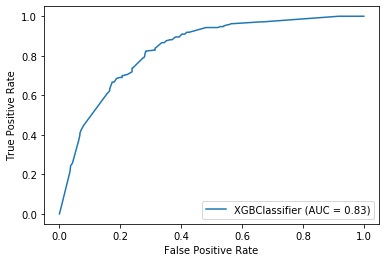

In [150]:
plot_roc_curve(cv_results3.best_estimator_, X_train, y_train)

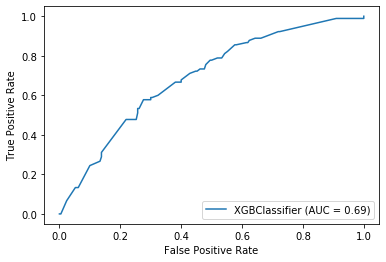

In [151]:
plot_roc_curve(cv_results3.best_estimator_, X_test, y_test)

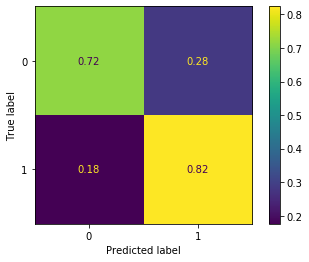

In [152]:
plot_confusion_matrix(cv_results3.best_estimator_, X_train, y_train, normalize='true')

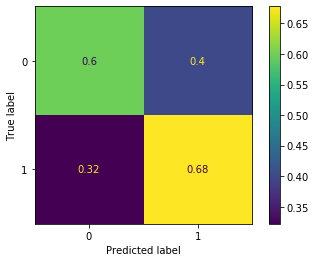

In [153]:
plot_confusion_matrix(cv_results3.best_estimator_, X_test, y_test, normalize='true')

In [154]:
y_pred_train = cv_results3.best_estimator_.predict(X_train)
(
    accuracy_score(y_train, y_pred_train),
    balanced_accuracy_score(y_train, y_pred_train)
)

(0.7485714285714286, 0.7700680272108844)

In [155]:
y_pred_test = cv_results3.best_estimator_.predict(X_test)
(
    accuracy_score(y_test, y_pred_test),
    balanced_accuracy_score(y_test, y_pred_test)
)

(0.6233333333333333, 0.6388888888888888)

### Random Forest

### Build feature pipeline

In [94]:
ord_attrs = ['account_check_status', 'savings']
num_attrs = ['credit_amount', 'duration_in_month', 'age']
cat_attrs = ['purpose', 'property', 'housing']

cat_pipeline = Pipeline([
    ('chi_sqr_filter', Chi2Filter(train_data.default, threshold=0.75)),
    ('one_hot_encoder', OneHotEncoder())
])

ord_pipeline = Pipeline([
    ('ord_enc', OrdinalEncoder())
])

num_pipeline = Pipeline([
    ('imput', SimpleImputer(strategy='median'))
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attrs),    
    ("ord", ord_pipeline, ord_attrs),
    ("cat", cat_pipeline, cat_attrs),
])

X_train = full_pipeline.fit_transform(train_data)
y_train = train_data.default.to_numpy()
X_test = full_pipeline.transform(test_data)
y_test = test_data.default.to_numpy()

X_train.tofile('/artifacts/X_train_subset.ndarr')
y_train.tofile('/artifacts/y_train_subset.ndarr')
X_test.tofile('/artifacts/X_test_subset.ndarr')
y_test.tofile('/artifacts/y_test_subset.ndarr')

Removing ['(vacation - does not exist?)' 'furniture/equipment' 'radio/television'
 'repairs']
Removing ['if not A121 : building society savings agreement/ life insurance'
 'if not A121/A122 : car or other, not in attribute 6']
Removing ['(vacation - does not exist?)' 'furniture/equipment' 'radio/television'
 'repairs']
Removing ['if not A121 : building society savings agreement/ life insurance'
 'if not A121/A122 : car or other, not in attribute 6']


In [129]:
param_grid = [{
    'n_estimators': [30, 40],
    'max_depth': [2, 3, 4],
    'max_features': [0.4, 0.6, 0.8],
    'max_samples': [0.6, 0.8, 1],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', 'balanced_subsample']
}]

forest_cls = RandomForestClassifier(oob_score=True)
skf = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(forest_cls, param_grid, cv=skf.split(X_train, y_train), scoring='f1', n_jobs=5, refit=True)

In [130]:
cv_results = grid_search.fit(X_train, y_train)
cv_results.best_params_

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fc778348ed0>,
             estimator=RandomForestClassifier(oob_score=True), n_jobs=5,
             param_grid=[{'class_weight': ['balanced', 'balanced_subsample'],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [2, 3, 4],
                          'max_features': [0.4, 0.6, 0.8],
                          'max_samples': [0.6, 0.8, 1],
                          'n_estimators': [30, 40]}],
             scoring='f1')

In [131]:
cv_results.best_estimator_.oob_score_

0.7271428571428571

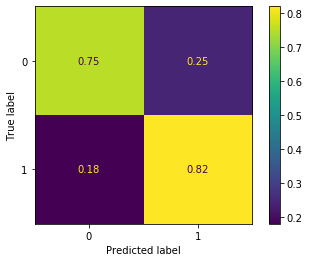

In [132]:
plot_confusion_matrix(cv_results.best_estimator_, X_train, y_train, normalize='true')

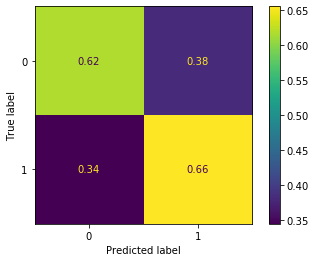

In [133]:
plot_confusion_matrix(cv_results.best_estimator_, X_test, y_test, normalize='true')

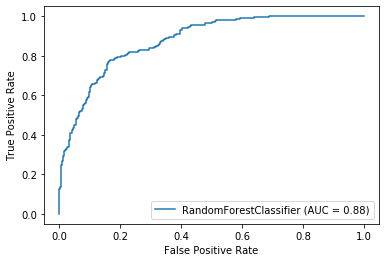

In [134]:
plot_roc_curve(cv_results.best_estimator_, X_train, y_train)

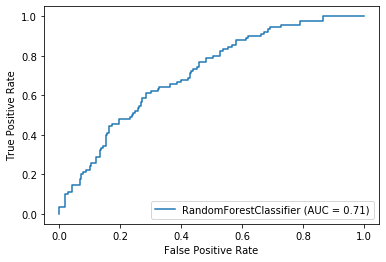

In [135]:
plot_roc_curve(cv_results.best_estimator_, X_test, y_test)


In [136]:
y_pred = grid_search.best_estimator_.predict(X_train)

(
    accuracy_score(y_train, y_pred),
    balanced_accuracy_score(y_train, y_pred)
)


(0.7728571428571429, 0.7860544217687075)

In [137]:
y_pred_test = cv_results.best_estimator_.predict(X_test)
(
    accuracy_score(y_test, y_pred_test),
    balanced_accuracy_score(y_test, y_pred_test)
)

(0.63, 0.6373015873015873)